# Parsing the Pubmed Abstracts

In [1]:
import pubmed.utils as pb
import json
import re
from collections import defaultdict
from pprint import pprint
import string
# utf-8 support
import codecs
import nltk
# spit abstracts to sentences
from nltk.tokenize import sent_tokenize
import ast
import pickle

#pandas!
import pandas as pd
import numpy as np
import re

In [2]:
# nltk.download('punkt')

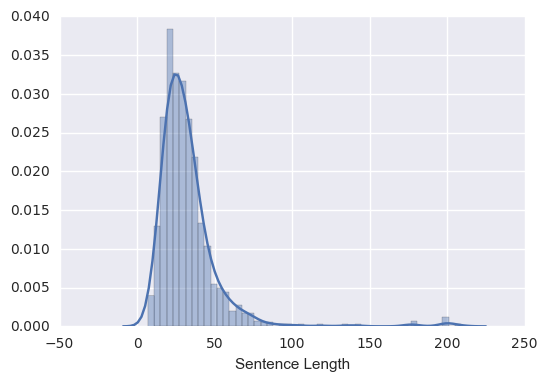

In [81]:
%matplotlib inline
import re 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

lengths_ = []


for item in open("/Users/lisabarcelo/Desktop/W266/food_drug_interaction/parsing/data/labeled_dataAll.tsv","r").readlines()[1:1000]:
    id_, label, label_num, drug, component, sentence = item.split("\t",5)
    words_ = [w for w in sentence.split(" ")]
    lengths_.append(len(words_))
    
sns.distplot(lengths_,axlabel="Sentence Length")

In [38]:
orig_dict = {}

i = 0
import re 
#for item in open("sent_files/glp_sent.tsv","r"):
for item in open("/Users/lisabarcelo/Desktop/W266/food_drug_interaction/parsing/data/labeled_dataAll.tsv","r").readlines()[1:1000]:
    #sent_id, sentiment, compound, sentence = item.split("\t",3)
    i += 1
    id_, label, label_num, drug, component, sentence = item.split("\t",5)
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = sentence.replace(";"," ")
    sentence = sentence.replace('"',' ')
    #sentence = re.sub("\d+","",re.sub(r'[^\w\s]','',sentence))
    words_ = [w for w in sentence.split(" ")]
    if len(words_) >= 30:
        #print " ".join([w for w in words_][:30]),"."
        orig_dict['Sentence #'+str(i)] = label
    else:
        #print sentence.encode('utf-8')
        orig_dict['Sentence #'+str(i)] = label

In [4]:
%%writefile sent_files/for_SSA.py

import re 
for item in open("/Users/lisabarcelo/Desktop/W266/food_drug_interaction/parsing/data/labeled_dataAll.tsv","r").readlines()[1:1000]:
    id_, label, label_num, drug, component, sentence = item.split("\t",5)
    sentence = re.sub(r'\([^)]*\)', '', sentence)
    sentence = sentence.replace(";"," ")
    sentence = sentence.replace('"',' ')
    sentence = re.sub("\d+","",re.sub(r'[^\w\s]','',sentence))
    words_ = [w for w in sentence.split(" ")]
    if len(words_) >= 30:
        print " ".join([w for w in words_][:30]),"."
    else:
        print sentence.encode('utf-8'),"."

Overwriting sent_files/for_SSA.py


In [5]:
!python2 sent_files/for_SSA.py > sent_files/ssa_all.txt

In [6]:
!head sent_files/ssa_all.txt

 iodine labelled betamethyliodophenyl pentadecanoic acid myocardial single photon emission computed tomography showed decreased uptake of the inferior segment in the early image whereas the delayed images revealed significant fillin .
Phenylethanol is a widely used aroma compound with roselike fragrance and Lhomophenylalanine is a building block of angiotensinconverting enzyme  inhibitor
.
 dihydroxyphenylacetic acid and methylcatechol  also inhibited both APN and ACE activity but not NEP activity   
.
A well microplate format of this method was used to screen the ACE inhibitory potential of peptides fractionated from an enzymatic hydrolysate of arachin
.
 A biochemical study was performed in order to analyse the effect of the NOdonors SIN and diethylamineNO  and of an aqueous solution of nitric oxide on the ACE .
A combination of ACEI  and VK  was administered for  months following curative therapy for HCC
.


In [7]:
!chmod a+x lexparser.sh

## Command Line Sentiment Analysis

This creates an output file with tuples and sentiments!

In [8]:
!java -cp "*" -Xmx2g edu.stanford.nlp.pipeline.StanfordCoreNLP \
-annotators tokenize,ssplit,pos,lemma,ner,parse,dcoref,sentiment \
-file sent_files/ssa_all.txt \
-outputFormat text

[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator tokenize
[main] INFO edu.stanford.nlp.pipeline.TokenizerAnnotator - No tokenizer type provided. Defaulting to PTBTokenizer.
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ssplit
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator pos
[main] INFO edu.stanford.nlp.tagger.maxent.MaxentTagger - Loading POS tagger from edu/stanford/nlp/models/pos-tagger/english-left3words/english-left3words-distsim.tagger ... done [1.5 sec].
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator lemma
[main] INFO edu.stanford.nlp.pipeline.StanfordCoreNLP - Adding annotator ner
[main] INFO edu.stanford.nlp.ie.AbstractSequenceClassifier - Loading classifier from edu/stanford/nlp/models/ner/english.all.3class.distsim.crf.ser.gz ... done [2.5 sec].
[main] INFO edu.stanford.nlp.ie.AbstractSequenceClassifier - Loading classifier from edu/stanford/nlp/models/ner/english.muc.7cla

In [9]:
!cat ssa_all.txt.out > sent_files/output_file.json

In [80]:
# !head sent_files/output_file.json

## Verification
Look up sentences and see how their manual sentiment compares with the SSA sentiment.

In [36]:
ssa_dict = {}
for line in open('sent_files/output_file.json').readlines():
    if 'Sentence #' in line:
        sent, num, _,_,_,_ = line.split(" ", 5)
        sentiment = str(line.strip('\n')).split(":")[1]
        sentiment = re.sub("\d+","",re.sub(r'[^\w\s]','',sentiment))
        #print sent,num, sentiment.lower()
        ssa_dict[sent + " " + num] = sentiment.lower()
        
        #this is because the SSA also has "very negative" as a sentiment
        if 'negative' in sentiment:
            ssa_dict[sent + " " + num] = 'negative'
        else:
            ssa_dict[sent + " " + num] = sentiment.lower().strip(" ")

In [39]:
print len(orig_dict.keys()), "vs", len(ssa_dict.keys())

999 vs 999


In [79]:
#Make two Dictionaries

correct = 0
incorrect = 0
total = 0

y_true = []
y_pred = []
#now iterate through and verify!
for k,v in ssa_dict.iteritems():
    y_pred.append(ssa_dict[k])
    y_true.append(orig_dict[k])
    try:
        total += 1
        if ssa_dict[k] == orig_dict[k]:
            correct +=1
        else:
            incorrect +=1
    except:
        pass
print "Accuracy: ", round(float(correct)/float(total),3) * 100, "% , Correct: ", correct, "Incorrect: ", incorrect, " Total: ", total

Accuracy:  13.2 % , Correct:  132 Incorrect:  867  Total:  999


## Confusion Matrix

In [78]:
import sklearn
import itertools
sklearn.metrics.confusion_matrix(y_true, y_pred_rand, labels=None)

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [ 35,  32,  31,   0,   0,   0],
       [169, 209, 216,   0,   0,   0],
       [108, 104,  95,   0,   0,   0]])

RNN: Confusion matrix, without normalization
[[ 95   2   1]
 [554  30  10]
 [286  14   7]]
RNN: Normalized confusion matrix
[[ 0.97  0.02  0.01]
 [ 0.93  0.05  0.02]
 [ 0.93  0.05  0.02]]


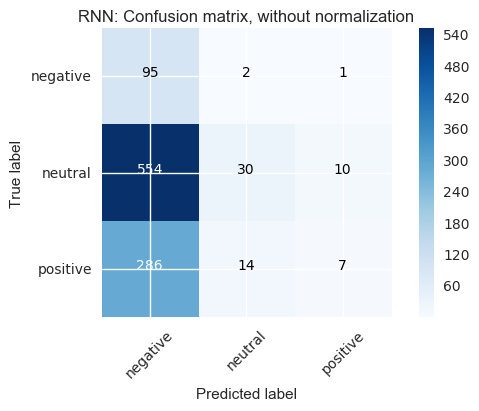

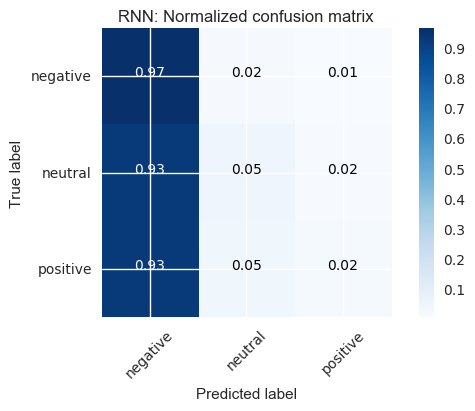

In [68]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("RNN: Normalized confusion matrix")
    else:
        print('RNN: Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['negative','neutral','positive'],
                      title='RNN: Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['negative','neutral','positive'], normalize=True,
                      title='RNN: Normalized confusion matrix')

plt.show()